In [ ]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import load_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import matplotlib.pyplot as plt
import seaborn as sns
#from patchify import patchify
import tifffile as tiff
from skimage import io
import pickle

import random
random.seed(100)

print('tensorflow version',tf.__version__)
print('keras version', keras.__version__)

!pip install keras-unet-collection
from keras_unet_collection import models, losses
!pip install segmentation_models
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()
%matplotlib inline

tensorflow version 2.8.0
keras version 2.8.0
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 50 kB 5.2 MB/s 
Segmentation Models: using `keras` framework.


**Loading the train-test datasets**

In [ ]:
X_train = np.load('/content/drive/MyDrive/seismic_facies_train_test_data/X_train.npy',allow_pickle=True,mmap_mode='r')
y_train = np.load('/content/drive/MyDrive/seismic_facies_train_test_data/y_train.npy',allow_pickle=True,mmap_mode='r')
X_test = np.load('/content/drive/MyDrive/seismic_facies_train_test_data/X_test.npy',allow_pickle=True,mmap_mode='r')
y_test = np.load('/content/drive/MyDrive/seismic_facies_train_test_data/y_test.npy',allow_pickle=True,mmap_mode='r')

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

**Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# credit: DigitalSreeni

def multi_unet_model(n_classes=6, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    
    s = data_augmentation(s)
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
"""
credit:
@author: Aldi Faizal Dimara
"""
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [ ]:
model = multi_unet_model(n_classes=6, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1)
model.compile(optimizer='adam', loss=[categorical_focal_loss(alpha=[ [ 1.01833657,  0.37961082,  3.34285935,  0.61222313, 18.06211106,  2.52634665]], gamma=2)],  metrics=['accuracy',jacard_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=80, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    )

Epoch 1/80
44/44 [==============================] - 20s 336ms/step - loss: 107.3086 - accuracy: 0.2140 - jacard_coef: 0.0906 - val_loss: 106.2685 - val_accuracy: 0.4294 - val_jacard_coef: 0.0927
Epoch 2/80
44/44 [==============================] - 11s 240ms/step - loss: 106.1113 - accuracy: 0.1712 - jacard_coef: 0.0908 - val_loss: 105.9750 - val_accuracy: 0.2638 - val_jacard_coef: 0.0913
Epoch 3/80
44/44 [==============================] - 11s 241ms/step - loss: 104.2234 - accuracy: 0.1512 - jacard_coef: 0.0896 - val_loss: 102.2246 - val_accuracy: 0.4000 - val_jacard_coef: 0.0912
Epoch 4/80
44/44 [==============================] - 11s 240ms/step - loss: 106.3857 - accuracy: 0.2594 - jacard_coef: 0.0917 - val_loss: 106.2127 - val_accuracy: 0.4303 - val_jacard_coef: 0.0921
Epoch 5/80
44/44 [==============================] - 11s 240ms/step - loss: 105.9324 - accuracy: 0.2331 - jacard_coef: 0.0911 - val_loss: 105.9370 - val_accuracy: 0.3465 - val_jacard_coef: 0.0923
Epoch 6/80
44/44 [=======

In [ ]:
#model.save('/content/drive/MyDrive/seismic_facies_unet.hdf5')

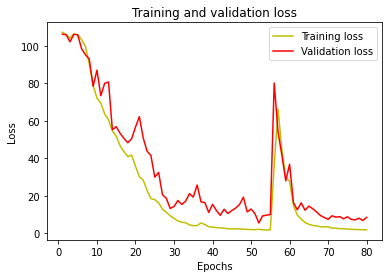

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

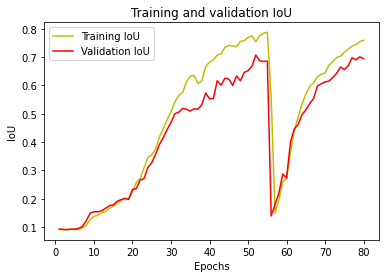

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/seismic_facies_unet.hdf5",
                   custom_objects={'focal_loss': categorical_focal_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.87851316


In [ ]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

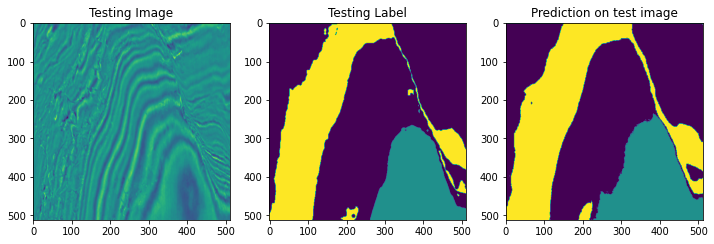

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

**Attention Unet**

In [ ]:
N = X_train.shape[-1]
inp = Input(shape=(512, 512, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels

model_att_unet = models.att_unet_2d((512,512,3),filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=6, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           atten_activation='ReLU', attention='add', 
                           output_activation='Softmax', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

out = model_att_unet(l1)
model_att = Model(inp, out, name=model_att_unet.name)

model_att.compile(optimizer='adam', loss=[categorical_focal_loss(alpha=[ [ 1.01833657,  0.37961082,  3.34285935,  0.61222313, 18.06211106,  2.52634665]], gamma=2)],  metrics=['accuracy',jacard_coef])

print(model_att.summary())



att_unet_history = model_att.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = 4,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=50)


#model_att.save('seismic_facies_att_UNet_50epochs.hdf5')

/usr/local/lib/python3.7/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


Model: "attunet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 3)       6         
                                                                 
 attunet_model (Functional)  (None, 512, 512, 6)       28385066  
                                                                 
Total params: 28,385,072
Trainable params: 13,664,624
Non-trainable params: 14,720,448
_________________________________________________________________
None
Epoch 1/50
176/176 [==============================] - 78s 386ms/step - loss: 75.0978 - accuracy: 0.3087 - jacard_coef: 0.1398 - val_loss: 270.3580 - val_accuracy: 0.0402 - val_jacard_coef: 0.0495
Epoch 2/50
176/176 [==============================] - 65s 368ms/step - loss: 55.1124 - accuracy

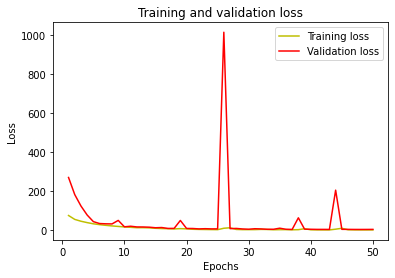

In [ ]:
history = att_unet_history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

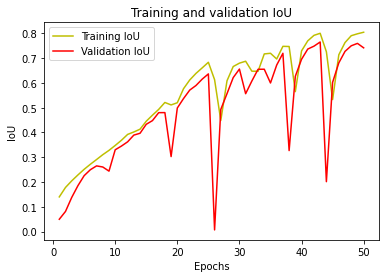

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
model_att = load_model('/content/drive/MyDrive/petr_models/seismic_facies_att_UNet_50epochs.hdf5',compile=False)

#IOU
y_pred=model_att.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8516523


In [ ]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_att.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

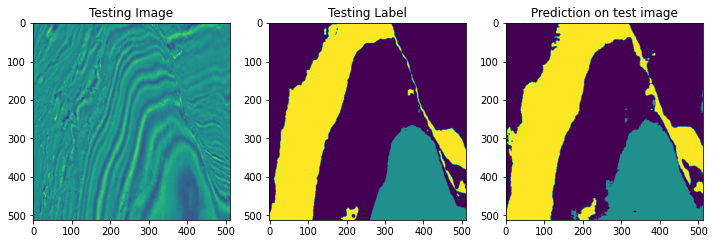

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

**Resnet34 Unet**

In [ ]:
N = X_train.shape[-1]
inp = Input(shape=(512, 512, N))
l1 = Conv2D(3, (1, 1))(inp)

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, classes=6, activation='softmax')
out = model1(l1)
model_res = Model(inp, out, name=model1.name)

# compile keras model with defined optimozer, loss and metrics
model_res.compile(optimizer='adam', loss=[categorical_focal_loss(alpha=[ [ 1.01833657,  0.37961082,  3.34285935,  0.61222313, 18.06211106,  2.52634665]], gamma=2)],  metrics=['accuracy',jacard_coef])


print(model_res.summary())


history1=model_res.fit(X_train1, 
          y_train,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test))


model_res.save('res34_backbone_50epochs.hdf5')

Received dilation rates: [1, 3, 15, 31]
Received dilation rates are not defined on a per downsampling level basis.
Automated determinations are applied with the following details:
	depth-0, dilation_rate = [1, 3, 15, 31]
	depth-1, dilation_rate = [1, 3, 15, 31]
	depth-2, dilation_rate = [1, 3, 15]
	depth-3, dilation_rate = [1]
Model: "res_a_block_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 3)       6         
                                                                 
 res_a_block_model (Function  (None, 512, 512, 6)      22066758  
 al)                                                             
                                                                 
Total params: 22,066,764
Trainable params: 22,042,

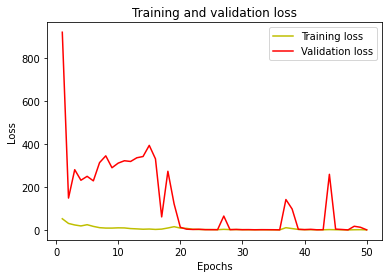

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

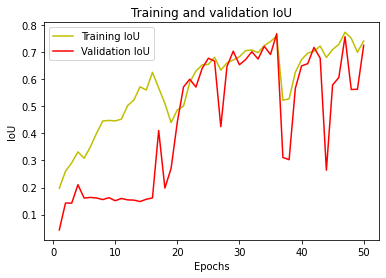

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
model_res = load_model('/content/res34_backbone_50epochs.hdf5',compile=False)

#IOU
y_pred=model_res.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83524007


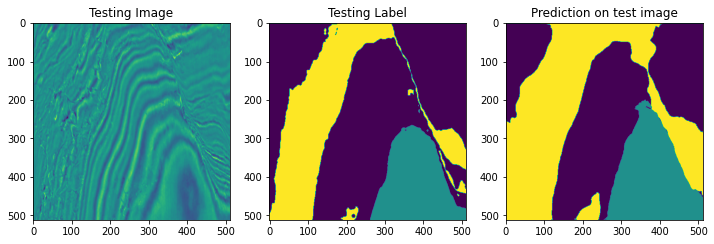

In [ ]:
#Predict on a few images
import random
test_img_number = 177
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_res.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

**Inceptionv3 Unet**

In [ ]:
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

N = X_train.shape[-1]
inp = Input(shape=(512, 512, N))
l1 = Conv2D(3, (1, 1))(inp)


# define model
model2 = sm.Unet(BACKBONE2, classes=6, activation='softmax')
out = model2(l1)
model_inp = Model(inp, out, name=model2.name)

# compile keras model with defined optimozer, loss and metrics

model_inp.compile(optimizer='adam', loss=[categorical_focal_loss(alpha=[ [ 1.01833657,  0.37961082,  3.34285935,  0.61222313, 18.06211106,  2.52634665]], gamma=2)],  metrics=['accuracy',jacard_coef])
print(model_inp.summary())


history1=model_inp.fit(X_train, 
          y_train,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))


model_inp.save('inceptionv3_backbone_50epochs.hdf5')

#####################################################

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_95 (Conv2D)          (None, 512, 512, 3)       6         
                                                                 
 model_1 (Functional)        (None, None, None, 6)     29933830  
                                                                 
Total params: 29,933,836
Trainable params: 29,897,420
Non-trainable params: 36,416
_________________________________________________________________
None
Epoch 1/50
88/88 [==============================] - 43s 341ms/step - loss: 49.8995 - accuracy: 0.4809 - jacard_coef: 0.2113 - val_loss: 975.6899 - val_accuracy: 0.0213 - val_jacard_coef: 0.0143
Epoch 2/50
88/88 [==============================] - 24s 275ms/step - loss: 31.5725 - accuracy: 0.5736 - jac

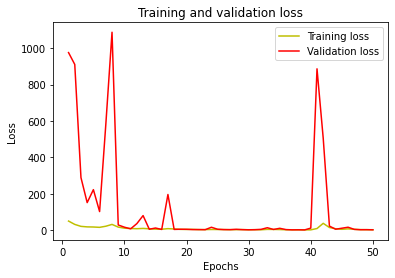

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

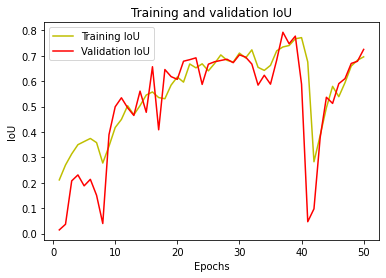

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
model_inp = load_model('/content/drive/MyDrive/petr_models/inceptionv3_backbone_50epochs.hdf5',compile=False)

#IOU
y_pred=model_res.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7606315


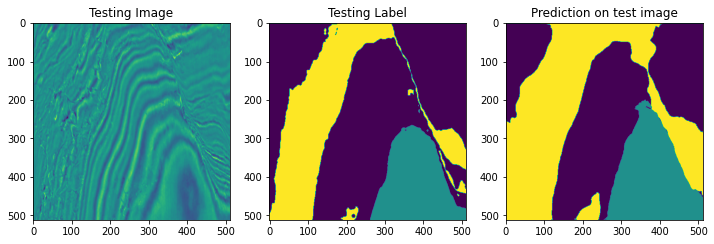

In [ ]:
#Predict on a few images
import random
test_img_number = 177
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_inp.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()